In [5]:
import cv2
import matplotlib.pyplot as plt
from ex1_utils import *

# Lucas Kanade

In [10]:
def lucaskanade(im1, im2, N):

    sigma = min(im1.shape)*0.005
    im1 = gausssmooth(im1, sigma)
    im2 = gausssmooth(im2, sigma)

    Ix1, Iy1 = gaussderiv(im1, sigma)
    Ix2, Iy2 = gaussderiv(im2, sigma)

    Ix = (Ix1 + Ix2) / 2
    Iy = (Iy1 + Iy2) / 2

    It = im2 - im1

    Ix2 = Ix * Ix
    IxIt = Ix * It

    Iy2 = Iy * Iy
    IyIt = Iy * It

    IxIy = Ix * Iy

    kernel = np.ones((N,N))

    SIx2 = cv2.filter2D(Ix2, -1, kernel)
    SIxIt = cv2.filter2D(IxIt, -1, kernel)

    SIy2 = cv2.filter2D(Iy2, -1, kernel)
    SIyIt = cv2.filter2D(IyIt, -1, kernel)

    SIxIy = cv2.filter2D(IxIy, -1, kernel)

    D = (SIx2 * SIy2) - (SIxIy**2)
    epsilon = 1e-6
    D = D + epsilon

    u = (-SIy2 * SIxIt + SIxIy * SIyIt) / D
    v = (SIxIy * SIxIt - SIx2 * SIyIt) / D

    return u, v

# Lucas Kanade with Harris response

In [23]:
def lucaskanadeharris(im1, im2, N, HD=5, k=0.04, H_threshold = 0.01):

    sigma = min(im1.shape)*0.005
    im1 = gausssmooth(im1, sigma)
    im2 = gausssmooth(im2, sigma)

    Ix1, Iy1 = gaussderiv(im1, sigma)
    Ix2, Iy2 = gaussderiv(im2, sigma)

    Ix = (Ix1 + Ix2) / 2
    Iy = (Iy1 + Iy2) / 2

    It = im2 - im1

    Ix2 = Ix * Ix
    IxIt = Ix * It

    Iy2 = Iy * Iy
    IyIt = Iy * It

    IxIy = Ix * Iy

    kernel = np.ones((N,N))

    SIx2 = cv2.filter2D(Ix2, -1, kernel)
    SIxIt = cv2.filter2D(IxIt, -1, kernel)

    SIy2 = cv2.filter2D(Iy2, -1, kernel)
    SIyIt = cv2.filter2D(IyIt, -1, kernel)

    SIxIy = cv2.filter2D(IxIy, -1, kernel)

    D = (SIx2 * SIy2) - (SIxIy**2)
    epsilon = 1e-6
    D = D + epsilon

    u = (-SIy2 * SIxIt + SIxIy * SIyIt) / D
    v = (SIxIy * SIxIt - SIx2 * SIyIt) / D

    #Harris corner detector
    harris_kernel = np.ones((HD, HD))

    H_Ix2 = cv2.filter2D(Ix2, -1, harris_kernel)
    H_Iy2 = cv2.filter2D(Iy2, -1, harris_kernel)
    H_Ixy = cv2.filter2D(IxIy, -1, harris_kernel)

    det = (H_Ix2 * H_Iy2) - (H_Ixy ** 2)
    trace = H_Ix2 + H_Iy2

    c = det - k * trace

    corners_matrix = (c > H_threshold)
    return u*corners_matrix, v*corners_matrix

# Horn Schunk

In [11]:
def hornschunck(im1, im2, n_iters, lam, threshold):

    sigma = min(im1.shape)*0.005
    im1 = gausssmooth(im1, sigma)
    im2 = gausssmooth(im2, sigma)

    Ix1, Iy1 = gaussderiv(im1, sigma)
    Ix2, Iy2 = gaussderiv(im2, sigma)

    Ix = (Ix1 + Ix2) / 2
    Iy = (Iy1 + Iy2) / 2

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy

    It = im2 - im1

    u = np.zeros(im1.shape)
    v = np.zeros(im1.shape)

    kernel = np.array([[0, 1/4, 0],
                       [1/4, 0, 1/4],
                       [0, 1/4, 0]])
    
    N = im1.shape[0] * im1.shape[1]

    for _ in range(n_iters):

        u_bar = cv2.filter2D(u, -1, kernel)
        v_bar = cv2.filter2D(v, -1, kernel)

        P = It + Ix * u_bar + Iy * v_bar
        D = Ix2 + Iy2 + lam + 1e-6

        u = u_bar - Ix * (P / D)
        v = v_bar - Iy * (P / D)

        sq_diff_u = (u_bar - u) ** 2
        sq_diff_v = (v_bar - v) ** 2

        total_diffs = sq_diff_u + sq_diff_v
        if (np.sum(total_diffs)/N) < threshold:
            return u_bar, v_bar

    return u, v

# Image importing

In [33]:
img1 = cv2.imread("disparity/cporta_left.png")
img2 = cv2.imread("disparity/cporta_right.png")


img1 = np.random.rand(200, 200).astype(np.float32)
img2 = img1.copy()
img2 = rotate_image(img2, -1)

if len(img1.shape) >= 3:
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

if len(img2.shape) >= 3:
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Visualisation

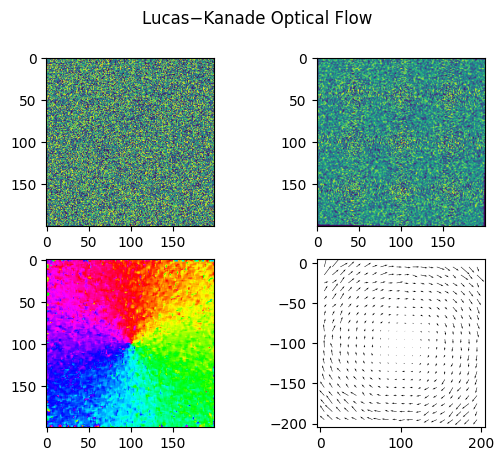

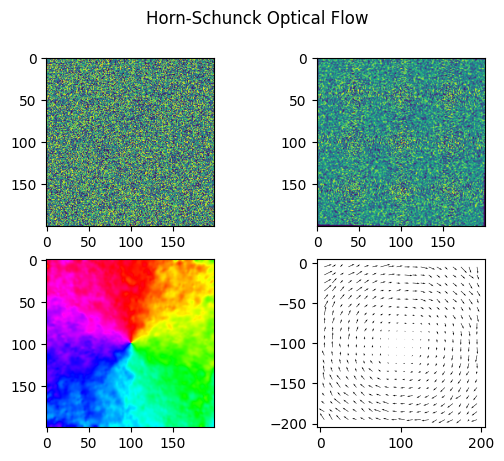

In [ ]:
U_lk, V_lk = lucaskanade(img1, img2, 4)
U_hs, V_hs = hornschunck(img1, img2, 1000, 0.5, 0.0001)


fig1, ((ax1_11 ,ax1_12) ,(ax1_21, ax1_22)) = plt.subplots(2, 2)
ax1_11.imshow(img1)
ax1_12.imshow(img2)
show_flow(U_lk ,V_lk, ax1_21, type='angle')
show_flow(U_lk ,V_lk ,ax1_22 ,type='field', set_aspect=True)
fig1.suptitle('Lucas−Kanade Optical Flow')

fig2, ((ax2_11 ,ax2_12) ,(ax2_21, ax2_22)) = plt.subplots(2, 2)
ax2_11.imshow(img1)
ax2_12.imshow(img2)
show_flow(U_hs ,V_hs, ax2_21, type='angle')
show_flow(U_hs ,V_hs ,ax2_22 ,type='field', set_aspect=True)
fig2.suptitle('Horn-Schunck Optical Flow')

plt.show()

In [ ]:
lucaskanadeharris(img1, img2, 3, H_threshold=50)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(416, 607)),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(416, 607)))